In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import sys
sys.path.append('../../')

from pprint import pprint
import numpy as np
import descarteslabs as dl

from src.ReMasFrame import *

nasa_df = ReMasFrame()

# Choose an idx --> a landslide (or filter the geodataframe :D)
idx_test = 11031

# changes Point to Polygon
# nasa_df_polygon = nasa_df.create_box(8000000)

# Returns products that we use as a dict
products = nasa_df.get_products()

nasa_df.loc[idx_test, :]

/home/step/miniconda3/envs/projectx/lib/python3.8/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


location_description        Ayu, Ozgon, Osh, Kyrgyzstan
landslide_size                                    large
event_date                                   2017-04-29
landslide_category                  translational_slide
landslide_trigger                              downpour
fatality_count                                       24
injury_count                                        NaN
longitude                                       73.4724
latitude                                        40.8864
geometry                POINT (73.47237853 40.88639497)
Name: 11031, dtype: object

In [3]:
pprint(products['elevation'])

{'aster': {'bands': ['alpha', 'height', 'number_images'],
           'id': 'aster:gdem3:v0',
           'res': '30m'}}


In [4]:
def get_scenes(product, buffer_size, res):
    # Returns start and end date of a 4 day interval
    start_date, end_date = nasa_df.date_interval(nasa_df.event_date[idx_test], delta_minus=10)
    
    scenes, ctx = ReMasFrame.search_scenes(
        nasa_df['geometry'][idx_test].buffer(buffer_size).envelope, 
        product['id'], 
        start_date=start_date, 
        end_date=end_date, 
        limit=20
    )
    
    new_ctx = ctx.assign(resolution=res)
    
    return scenes, new_ctx, start_date, end_date

def get_composite(product, buffer_size, res):
    
    scenes, new_ctx = get_scenes(product, buffer_size, res)
    
    arr_stack = scenes.stack(product['bands'], new_ctx)
    composite = np.ma.median(arr_stack, axis=0)
    
    return (scenes, new_ctx), composite

In [5]:
products['elevation']['aster']['bands'], len(products['elevation']['aster']['bands'])

(['alpha', 'height', 'number_images'], 3)

In [30]:
def get_dem(product):
    # Returns start and end date of a 4 day interval
    scenes, ctx = ReMasFrame.search_scenes(
        nasa_df['geometry'][idx_test].buffer(1).envelope, 
        product['id'], 
        start_date='2013-10-01', 
        end_date='2013-12-01', 
        limit=10
    )

    new_ctx = ctx.assign(resolution= 0.001)
    arr_stack = scenes.stack("height", new_ctx)

    composite = np.ma.median(arr_stack, axis=0)
    return (scenes, new_ctx), composite

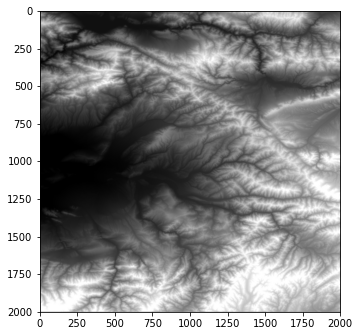

In [31]:
(scenes, ctx), composite = get_dem(products['elevation']['aster'])
dl.scenes.display(composite, size=5)

In [32]:
scenes[0].ndarray("alpha", ctx)

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [255, 255, 255, ..., --, --, --],
         [255, 255, 255, ..., --, --, --],
         [--, --, --, ..., --, --, --]]],
  mask=[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [False, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]]],
  fill_value=999999,
  dtype=uint8)